# Import libraries

In [1]:
import requests
import json
import os
import matplotlib.pyplot as plt
from shapely.geometry import shape, MultiPolygon, Polygon
import pandas as pd
import geopandas as gpd
from shapely import wkt
from pandas.api.types import is_object_dtype
from pandas.api.types import CategoricalDtype

# Read the `CSV` and make plots

In [2]:
def read_geo_df(path: str):
    df = pd.read_csv(path)
    df['geometry'] = df['geometry'].apply(wkt.loads)
    gdf = gpd.GeoDataFrame(df, geometry='geometry')
    gdf.set_crs("EPSG:4326", inplace=True)
    return df, gdf

def print_df_info(df, name):
    print(f"--- Info for {name} ---")
    print("Dimensions:", df.shape)
    print("Columns:", df.columns.tolist())
    print("Unique YEAR_ values:", df['YEAR_'].unique())
    print()

In [4]:
ca_fire_0_df, ca_fire_0_gdf = read_geo_df("/Users/davidliu/Desktop/IASC-2025/data/california_fire_perimeters_0.csv")
print_df_info(ca_fire_0_gdf, "ca_fire_0_df")

--- Info for ca_fire_0_df ---
Dimensions: (22810, 22)
Columns: ['OBJECTID', 'YEAR_', 'STATE', 'AGENCY', 'UNIT_ID', 'FIRE_NAME', 'INC_NUM', 'ALARM_DATE', 'CONT_DATE', 'CAUSE', 'C_METHOD', 'OBJECTIVE', 'GIS_ACRES', 'COMMENTS', 'COMPLEX_NAME', 'IRWINID', 'FIRE_NUM', 'COMPLEX_ID', 'DECADES', 'Shape__Area', 'Shape__Length', 'geometry']
Unique YEAR_ values: [2025. 2024. 2023. 2022. 2021. 2020. 2019. 2018. 2017. 2016. 2015. 2014.
 2013. 2012. 2011. 2010. 2009. 2008. 2007. 2006. 2005. 2004. 2003. 2002.
 2001. 2000. 1999. 1998. 1997. 1996. 1995. 1994. 1993. 1992. 1991. 1990.
 1989. 1988. 1987. 1986. 1985. 1984. 1983. 1982. 1981. 1980. 1979. 1978.
 1977. 1976. 1975. 1974. 1973. 1972. 1971. 1970. 1969. 1968. 1967. 1966.
 1965. 1964. 1963. 1962. 1961. 1960. 1959. 1958. 1957. 1956. 1955. 1954.
 1953. 1952. 1951. 1950. 1949. 1948. 1947. 1946. 1945. 1944. 1943. 1942.
 1941. 1940. 1939. 1938. 1937. 1936. 1935. 1934. 1933. 1932. 1931. 1930.
 1929. 1928. 1927. 1926. 1925. 1924. 1923. 1922. 1921. 1920. 1

# Extract fires only happened inside the Los Angeles city boundary

In [5]:
def filter_fires_in_boundary(fire_gdf, boundary_gdf, mode="within"):
    fire_gdf = fire_gdf.to_crs(boundary_gdf.crs)
    boundary_union = boundary_gdf.geometry.union_all()
    
    if mode == "within":
        filtered_fires = fire_gdf[fire_gdf.geometry.within(boundary_union)]
    elif mode == "intersects":
        filtered_fires = fire_gdf[fire_gdf.geometry.intersects(boundary_union)]
    else:
        raise ValueError("mode must be 'within' or 'intersects'")
    
    return filtered_fires

def fix_invalid_geometries(gdf):
    # Attempt to fix invalid geometries using buffer(0)
    gdf['geometry'] = gdf.geometry.buffer(0)
    # Drop any that remain invalid (optional)
    gdf = gdf[gdf.is_valid]
    return gdf

def clip_fires_to_boundary(fire_gdf, boundary_gdf):
    fire_gdf = fire_gdf.to_crs(boundary_gdf.crs)
    fire_gdf = fix_invalid_geometries(fire_gdf)
    
    boundary_union = boundary_gdf.geometry.union_all()
    clipped_fires = gpd.clip(fire_gdf, boundary_union)
    return clipped_fires

<Axes: >

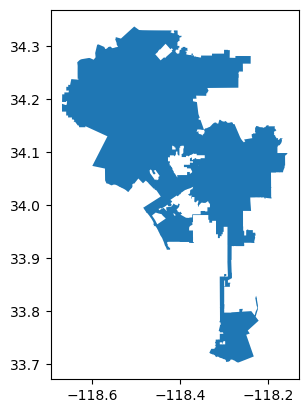

In [7]:
la_boundary = gpd.read_file('/Users/davidliu/Desktop/IASC-2025/data/la_city_boundary.geojson')
la_boundary.plot()

In [9]:
# Filter out the fires around and inside the LA city boundary
la_fire_0_gdf = filter_fires_in_boundary(ca_fire_0_gdf, la_boundary, mode="intersects")
la_fire_0_gdf_clipped = clip_fires_to_boundary(ca_fire_0_gdf, la_boundary)

# Take a close look to the LA only data

In [11]:
la_fire_0_gdf_clipped.to_csv("/Users/davidliu/Desktop/IASC-2025/data/la_fire_0_gdf_clipped.csv", index=False)

In [12]:
df_trees = pd.read_csv("/Users/davidliu/Desktop/IASC-2025/data/la_trees_combined.csv")

In [13]:
df_trees.shape

(848194, 5)

In [14]:
gdf_fire = la_fire_0_gdf_clipped.copy()

# Merge Fire and Tree (92768 rows with 55013 unique trees)

In [17]:
# 1. Add a unique ID to each tree
df_trees['tree_id'] = range(len(df_trees))

# 2. Build the tree GeoDataFrame (now contains tree_id)
gdf_trees = gpd.GeoDataFrame(
    df_trees,
    geometry=gpd.points_from_xy(df_trees.Longitude, df_trees.Latitude),
    crs="EPSG:4326"
)

# 3. Ensure fires have the same CRS
gdf_fire = gdf_fire.set_crs("EPSG:4326", allow_override=True)

# 4. Spatial-join: attach fire attributes to each tree within a fire
gdf_merged = gpd.sjoin(
    gdf_trees,
    gdf_fire,
    how="inner",
    predicate="within"
).reset_index(drop=True)

# Now gdf_merged has a column 'tree_id' you can use to trace back each original tree
gdf_merged

,Latitude,Longitude,Species,DBH,Any_Protected,tree_id,geometry,index_right,OBJECTID,YEAR_,...,OBJECTIVE,GIS_ACRES,COMMENTS,COMPLEX_NAME,IRWINID,FIRE_NUM,COMPLEX_ID,DECADES,Shape__Area,Shape__Length
0,34.154814,-118.589896,coast live oak (Quercus agrifolia),25.0,False,398,POINT (-118.5899 34.15481),18162,18164,1944.0,...,1.0,4548.5230,NaN,NaN,NaN,00000000,NaN,1950-1959,2.694018e+07,35271.399924
1,34.154815,-118.589929,coast live oak (Quercus agrifolia),13.0,False,399,POINT (-118.58993 34.15482),18162,18164,1944.0,...,1.0,4548.5230,NaN,NaN,NaN,00000000,NaN,1950-1959,2.694018e+07,35271.399924
2,34.275480,-118.541392,MyLA311 Added (MyLA311 Added),0.0,False,782,POINT (-118.54139 34.27548),15796,15798,1959.0,...,1.0,624.3035,NaN,NaN,NaN,00000000,NaN,1950-1959,3.709861e+06,8002.545419
3,34.275480,-118.541392,MyLA311 Added (MyLA311 Added),0.0,False,782,POINT (-118.54139 34.27548),17346,17348,1950.0,...,1.0,4233.7710,NaN,NaN,NaN,00000000,NaN,1950-1959,2.516131e+07,31893.552189
4,34.145944,-118.505713,MyLA311 Added (MyLA311 Added),0.0,False,1620,POINT (-118.50571 34.14594),15672,15674,1960.0,...,1.0,80.7574,NaN,NaN,NaN,00000000,NaN,1960-1969,4.783674e+05,4025.625330
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92763,34.281985,-118.524873,swamp mallee (Eucalyptus spathulata),1.0,False,848183,POINT (-118.52487 34.28199),17825,17827,1947.0,...,1.0,416.0731,NaN,NaN,NaN,00000000,NaN,1950-1959,2.472436e+06,7602.760800
92764,34.281909,-118.524855,cork oak (Quercus suber),1.0,False,848184,POINT (-118.52486 34.28191),17825,17827,1947.0,...,1.0,416.0731,NaN,NaN,NaN,00000000,NaN,1950-1959,2.472436e+06,7602.760800
92765,34.281829,-118.524832,cork oak (Quercus suber),1.0,False,848185,POINT (-118.52483 34.28183),17825,17827,1947.0,...,1.0,416.0731,NaN,NaN,NaN,00000000,NaN,1950-1959,2.472436e+06,7602.760800
92766,34.281753,-118.524804,cork oak (Quercus suber),1.0,False,848186,POINT (-118.5248 34.28175),17825,17827,1947.0,...,1.0,416.0731,NaN,NaN,NaN,00000000,NaN,1950-1959,2.472436e+06,7602.760800


In [18]:
gdf_merged.to_csv("/Users/davidliu/Desktop/IASC-2025/data/la_trees_fire_92768.csv", index=False)

# Drop the duplicate trees remain to 55013 rows

In [20]:
# Keep only the first occurrence of each tree
fire_tree_unique = gdf_merged.drop_duplicates(subset='tree_id')

In [21]:
fire_tree_unique.shape

(55013, 29)

# Next Step

1. Add new feature tree appeared times
2. Y(GIS_ACRES) categorized to Large Fire, Medium fire, Small Fire
3. Drop useless columns
4. Clean the Trees Speices within 20~50 kinds
5. Function to determine the range

# 1. Add New feature: tree appeared times

In [22]:
tree_counts = gdf_merged["tree_id"].value_counts()
fire_tree_unique["tree_appear_count"] = fire_tree_unique["tree_id"].map(tree_counts)
fire_tree_unique.head()

/opt/anaconda3/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,Latitude,Longitude,Species,DBH,Any_Protected,tree_id,geometry,index_right,OBJECTID,YEAR_,...,GIS_ACRES,COMMENTS,COMPLEX_NAME,IRWINID,FIRE_NUM,COMPLEX_ID,DECADES,Shape__Area,Shape__Length,tree_appear_count
0,34.154814,-118.589896,coast live oak (Quercus agrifolia),25.0,False,398,POINT (-118.5899 34.15481),18162,18164,1944.0,...,4548.5230,NaN,NaN,NaN,00000000,NaN,1950-1959,2.694018e+07,35271.399924,1
1,34.154815,-118.589929,coast live oak (Quercus agrifolia),13.0,False,399,POINT (-118.58993 34.15482),18162,18164,1944.0,...,4548.5230,NaN,NaN,NaN,00000000,NaN,1950-1959,2.694018e+07,35271.399924,1
2,34.275480,-118.541392,MyLA311 Added (MyLA311 Added),0.0,False,782,POINT (-118.54139 34.27548),15796,15798,1959.0,...,624.3035,NaN,NaN,NaN,00000000,NaN,1950-1959,3.709861e+06,8002.545419,2
4,34.145944,-118.505713,MyLA311 Added (MyLA311 Added),0.0,False,1620,POINT (-118.50571 34.14594),15672,15674,1960.0,...,80.7574,NaN,NaN,NaN,00000000,NaN,1960-1969,4.783674e+05,4025.625330,1
5,34.089382,-118.452487,coast live oak (Quercus agrifolia),10.0,False,1826,POINT (-118.45249 34.08938),15424,15426,1961.0,...,6151.9790,NaN,NaN,NaN,00000000,NaN,1960-1969,3.640036e+07,48599.914373,1


In [23]:
fire_tree_unique[["OBJECTID", "GIS_ACRES"]]

,OBJECTID,GIS_ACRES
0,18164,4548.5230
1,18164,4548.5230
2,15798,624.3035
4,15674,80.7574
5,15426,6151.9790
...,...,...
92763,17827,416.0731
92764,17827,416.0731
92765,17827,416.0731
92766,17827,416.0731


In [24]:
fire_summary = fire_tree_unique[['OBJECTID', 'GIS_ACRES']].drop_duplicates().sort_values(by='GIS_ACRES', ascending=False)
fire_summary = fire_summary.reset_index(drop=True)

In [25]:
fire_summary

,OBJECTID,GIS_ACRES
0,5463,160833.100000
1,14215,115537.400000
2,21333,70796.410000
3,22734,59468.880000
4,13385,51220.440000
...,...,...
198,4022,1.193676
199,14104,1.134497
200,13382,1.087449
201,13084,0.634698


# 2. Categorized GIS_ACRES: A, B, C, D, E, F, G, H

In [27]:
def categorize_fire_size_simple(acres):
    if acres < 100:
        return 'Small'
    elif acres < 1000:
        return 'Medium'
    elif acres < 10000:
        return 'Large'
    else:
        return 'Very Large'

# Apply to your DataFrame
fire_tree_unique['FIRE_SIZE_CATEGORY'] = fire_tree_unique['GIS_ACRES'].apply(categorize_fire_size_simple)

# Summary counts
print(fire_tree_unique['FIRE_SIZE_CATEGORY'].value_counts())


FIRE_SIZE_CATEGORY
Medium        21732
Very Large    18180
Large         10387
Small          4714
Name: count, dtype: int64


/opt/anaconda3/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [28]:
def categorize_fire_size_usda(acres):
    if acres < 0.25:
        return 'A - Small'
    elif acres < 10:
        return 'B - Small'
    elif acres < 100:
        return 'C - Small'
    elif acres < 300:
        return 'D - Medium'
    elif acres < 1000:
        return 'E - Medium'
    elif acres < 5000:
        return 'F - Large'
    elif acres < 10000:
        return 'G - Large'
    else:
        return 'G - Very Large'

# Apply to your DataFrame
fire_tree_unique['USDA_FIRE_SIZE_CLASS'] = fire_tree_unique['GIS_ACRES'].apply(categorize_fire_size_usda)

# Count by category
print(fire_tree_unique['USDA_FIRE_SIZE_CLASS'].value_counts())


USDA_FIRE_SIZE_CLASS
G - Very Large    18180
E - Medium        12631
D - Medium         9101
F - Large          6908
C - Small          4126
G - Large          3479
B - Small           588
Name: count, dtype: int64


/opt/anaconda3/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


# 3. Drop the Useless Columns

In [29]:
# Output the number of NA values for each column in ca_fire_0_df
na_counts = fire_tree_unique.isna().sum()
na_nonzero = na_counts[na_counts != 0]
print(na_nonzero)

INC_NUM             7
ALARM_DATE       2702
CONT_DATE       47306
C_METHOD        41511
OBJECTIVE         389
COMMENTS        45772
COMPLEX_NAME    55013
IRWINID         48742
FIRE_NUM         8129
COMPLEX_ID      55013
dtype: int64


In [30]:
cols_to_drop = ['INC_NUM', 'ALARM_DATE', 'CONT_DATE', 'C_METHOD', 'OBJECTIVE', 'COMMENTS', 'COMPLEX_NAME', 'IRWINID', "FIRE_NUM", "COMPLEX_ID"]

In [31]:
fire_tree_unique = fire_tree_unique.drop(columns=cols_to_drop)
fire_tree_unique.columns

Index(['Latitude', 'Longitude', 'Species', 'DBH', 'Any_Protected', 'tree_id',
       'geometry', 'index_right', 'OBJECTID', 'YEAR_', 'STATE', 'AGENCY',
       'UNIT_ID', 'FIRE_NAME', 'CAUSE', 'GIS_ACRES', 'DECADES', 'Shape__Area',
       'Shape__Length', 'tree_appear_count', 'FIRE_SIZE_CATEGORY',
       'USDA_FIRE_SIZE_CLASS'],
      dtype='object')

In [ ]:
fire_tree_unique.to_csv("/Users/davidliu/Desktop/IASC-2025/data/la_trees_fire_unique.csv", index=False)

# Clean the Tree Specise

In [34]:
import re

In [35]:
tree_df = fire_tree_unique.copy()

In [36]:
# Tree family rules (with Bignoniaceae included)
expanded_tree_families = {
    'Pine': ['Pinus'],
    'Oak': ['Quercus'],
    'Maple': ['Acer'],
    'Ash': ['Fraxinus'],
    'Fir': ['Abies'],
    'Cedar': ['Cedrus'],
    'Cypress': ['Cupressus', 'Hesperocyparis', 'Taxodium'],
    'Eucalyptus': ['Eucalyptus', 'Corymbia'],
    'Magnolia': ['Magnolia'],
    'Elm': ['Ulmus'],
    'Sycamore': ['Platanus'],
    'Willow': ['Salix'],
    'Juniper': ['Juniperus'],
    'Podocarpus': ['Podocarpus'],
    'Sweetgum': ['Liquidambar'],
    'Araucaria': ['Araucaria'],
    'Arbutus': ['Arbutus'],
    'Spruce': ['Picea'],
    'Acacia': ['Acacia'],
    'Desert Willow': ['Chilopsis'],
    'Birch': ['Betula'],
    'Douglas Fir': ['Pseudotsuga'],
    'She-oak': ['Allocasuarina'],
    'False Cypress': ['Chamaecyparis'],
    'Australian Willow': ['Geijera'],
    'Grevillea': ['Grevillea'],
    'Saltcedar': ['Tamarix'],
    'Fig': ['Ficus'],
    'Araucariaceae': ['Wollemia'],
    'Abutilon': ['Abutilon'],
    'Bignoniaceae': ['Chitalpa']  # Added Chitalpa here
}

# Rebuild genus-to-group mapping
genus_to_group = {
    genus.lower(): group
    for group, genera in expanded_tree_families.items()
    for genus in genera
}

# Function to extract genus (handles hybrid "×" or "x")
def extract_genus(species):
    match = re.search(r'\(([^)]+)\)', species)
    if match:
        parts = match.group(1).split()
    else:
        parts = species.split()
    for part in parts:
        if part.lower() not in ['×', 'x']:
            return part.strip().lower()
    return ''

# Function to assign group based on genus or keywords
def assign_tree_group(species):
    lname = species.lower()
    if 'palm' in lname:
        return 'Palm'
    elif any(kw in lname for kw in ['rose', 'shrub', 'bush', 'viburnum', 'camellia', 'cotoneaster', 'privet', 'gardenia', 'cassia']):
        return 'Shrub/Bush/Ornamental'
    elif any(kw in lname for kw in ['site', 'stump', 'default', 'property', 'unknown']):
        return 'Non-plant/Irrelevant'
    else:
        genus = extract_genus(species)
        return genus_to_group.get(genus, genus.capitalize())

# Apply the group assignment
tree_df['TreeGroup'] = tree_df['Species'].apply(assign_tree_group)

# Count group occurrences
group_counts = tree_df['TreeGroup'].value_counts()

valid_groups = group_counts[
    (group_counts > 10) &
    (~group_counts.index.isin(['Non-plant/Irrelevant', 'Shrub/Bush/Ornamental']))
].index

# Filter the DataFrame
tree_df = tree_df[tree_df['TreeGroup'].isin(valid_groups)].reset_index(drop=True)

In [37]:
tree_df['TreeGroup'].value_counts()

TreeGroup
Oak                12032
Eucalyptus          5889
Pine                5780
Sycamore            3241
Palm                2953
                   ...  
Carya                 14
Tristaniopsis         13
Pithecellobium        13
Cupressocyparis       12
Thuja                 11
Name: count, Length: 91, dtype: int64

In [38]:
tree_df.shape

(51896, 23)

In [40]:
tree_df.to_csv("/Users/davidliu/Desktop/IASC-2025/data/la_trees_fire_unique_grouped.csv", index=False)

# Add the Temp

In [41]:
tree_df_temp = pd.read_csv("/Users/davidliu/Desktop/IASC-2025/data/fire_tree_temp.csv")

In [43]:
tree_df_temp.columns, tree_df_temp.shape

(Index(['Unnamed: 0', 'Latitude', 'Longitude', 'Species', 'DBH',
        'Any_Protected', 'tree_id', 'geometry', 'index_right', 'OBJECTID',
        'YEAR_', 'STATE', 'AGENCY', 'UNIT_ID', 'FIRE_NAME', 'CAUSE',
        'GIS_ACRES', 'DECADES', 'Shape__Area', 'Shape__Length',
        'tree_appear_count', 'FIRE_SIZE_CATEGORY', 'Year', 'Annual'],
       dtype='object'),
 (55013, 24))

In [45]:
tree_df_temp[["Annual", "Year", "YEAR_"]]

,Annual,Year,YEAR_
0,62.2,1944,1944
1,62.2,1944,1944
2,67.3,1959,1959
3,65.6,1960,1960
4,65.3,1961,1961
...,...,...,...
55008,64.1,1947,1947
55009,64.1,1947,1947
55010,64.1,1947,1947
55011,64.1,1947,1947


In [46]:
# 1. Create a mapping from Year to Annual temperature
year_to_temp = tree_df_temp.drop_duplicates(subset='Year')[['Year', 'Annual']].set_index('Year')['Annual'].to_dict()


In [51]:
tree_df['Annual_Temp'] = tree_df['YEAR_'].map(year_to_temp)

In [57]:
tree_df.head()

,Latitude,Longitude,Species,DBH,Any_Protected,tree_id,geometry,index_right,OBJECTID,YEAR_,...,CAUSE,GIS_ACRES,DECADES,Shape__Area,Shape__Length,tree_appear_count,FIRE_SIZE_CATEGORY,USDA_FIRE_SIZE_CLASS,TreeGroup,Annual_Temp
0,34.154814,-118.589896,coast live oak (Quercus agrifolia),25.0,False,398,POINT (-118.5899 34.15481),18162,18164,1944.0,...,14,4548.5230,1950-1959,2.694018e+07,35271.399924,1,Large,F - Large,Oak,62.2
1,34.154815,-118.589929,coast live oak (Quercus agrifolia),13.0,False,399,POINT (-118.58993 34.15482),18162,18164,1944.0,...,14,4548.5230,1950-1959,2.694018e+07,35271.399924,1,Large,F - Large,Oak,62.2
2,34.275480,-118.541392,MyLA311 Added (MyLA311 Added),0.0,False,782,POINT (-118.54139 34.27548),15796,15798,1959.0,...,14,624.3035,1950-1959,3.709861e+06,8002.545419,2,Medium,E - Medium,Myla311,67.3
3,34.145944,-118.505713,MyLA311 Added (MyLA311 Added),0.0,False,1620,POINT (-118.50571 34.14594),15672,15674,1960.0,...,14,80.7574,1960-1969,4.783674e+05,4025.625330,1,Small,C - Small,Myla311,65.6
4,34.089382,-118.452487,coast live oak (Quercus agrifolia),10.0,False,1826,POINT (-118.45249 34.08938),15424,15426,1961.0,...,14,6151.9790,1960-1969,3.640036e+07,48599.914373,1,Large,G - Large,Oak,65.3


In [59]:
tree_df.shape

(51896, 24)

In [58]:
tree_df.to_csv("/Users/davidliu/Desktop/IASC-2025/data/la_trees_fire_temp.csv", index=False)